In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import random
import pickle
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

sns.set()

In [2]:
seed=random.randint(1, 10000000)

# Data Preparation

In [3]:
df_purchase=pd.read_csv('C:/Users/armaod/Documents/Customer-Analysis/data/purchase data.csv', index_col=0)

scaler = pickle.load(open('scaler.pickle', 'rb'))
pca = pickle.load(open('pca.pickle', 'rb'))
kmeans_pca= pickle.load(open('kmeans_pca.pickle', 'rb'))

features = df_purchase[['Sex', 'Marital status', 'Age', 'Education', 'Income','Occupation', 'Settlement size']]
df_pur_std = scaler.transform(features)

df_pur_std_pca = pca.transform(df_pur_std)

df_pur_std_pca_kmeans = kmeans_pca.predict(df_pur_std_pca)

df_pur_predictor = df_purchase.copy()
df_pur_predictor['segment'] = df_pur_std_pca_kmeans
segment_dummies = pd.get_dummies(df_pur_std_pca_kmeans, prefix = 'segment', prefix_sep = '_')
df_pur_predictor = pd.concat([df_pur_predictor.reset_index(), segment_dummies], axis=1)

df_pa = df_pur_predictor

In [4]:
df_pa

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,segment,segment_0,segment_1,segment_2,segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,47,1,110866,1,0,1,0,1,0,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,1,0,1,0,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,1,0,1,0,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,47,1,110866,1,0,1,0,1,0,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,47,1,110866,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58688,200000500,703,0,0,0,2,1,1.41,1.85,2.01,...,42,1,120946,1,0,1,0,1,0,0
58689,200000500,710,0,0,0,0,0,1.36,1.84,2.09,...,42,1,120946,1,0,1,0,1,0,0
58690,200000500,717,0,0,0,0,0,1.50,1.80,2.14,...,42,1,120946,1,0,1,0,1,0,0
58691,200000500,722,1,2,3,0,0,1.51,1.82,2.09,...,42,1,120946,1,0,1,0,1,0,0


# Purchase probability model

In [5]:
Y = df_pa['Incidence']

In [6]:
X = pd.DataFrame()
X['Mean price']=(df_pa['Price_1']+
                 df_pa['Price_2']+
                 df_pa['Price_3']+
                 df_pa['Price_4']+
                 df_pa['Price_5'])/5

In [7]:
model_pur = LogisticRegression(solver = 'sag')
model_pur.fit(X, Y)

LogisticRegression(solver='sag')

In [8]:
model_pur.coef_

array([[-2.34817728]])

## Price Elestasticity of purchase model

In [9]:
df_pa[['Price_1','Price_2','Price_3','Price_4','Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [23]:
price_range = np.arange(0.5, 3.5, 0.01)
df_price_range = pd.DataFrame(price_range)

Vogliamo stimare la probabilità di vendere o no un prodotto dato un prezzo 

In [26]:
Y_pr = model_pur.predict_proba(df_price_range)

C:\Users\armaod\AppData\Local\anaconda3\envs\PayInt\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [28]:
pur_pr = Y_pr [:][:, 1]

Vogliamo stimare l'elasticità del prezzo: E = (variazione prob)/(prob)/(variazione P)/P

La formula semplificata : beta * price * (1-pr(pur))

In [29]:
pe = model_pur.coef_[:,0] * price_range * (1 - pur_pr)

In [30]:
df_price_elasticity = pd.DataFrame(price_range)

In [31]:
pd.options.display.max_rows = None

In [32]:
df_price_elasticity =df_price_elasticity.rename(columns= {0 :"Price_Point"})
df_price_elasticity['Mean_Pe'] = pe
df_price_elasticity

,Price_Point,Mean_Pe
0,0.50,-0.096379
1,0.51,-0.100447
2,0.52,-0.104641
3,0.53,-0.108965
4,0.54,-0.113423
5,0.55,-0.118018
6,0.56,-0.122752
7,0.57,-0.127629
8,0.58,-0.132654
9,0.59,-0.137828


Text(0.5, 1.0, 'Price Elasticity of purchase Probability')

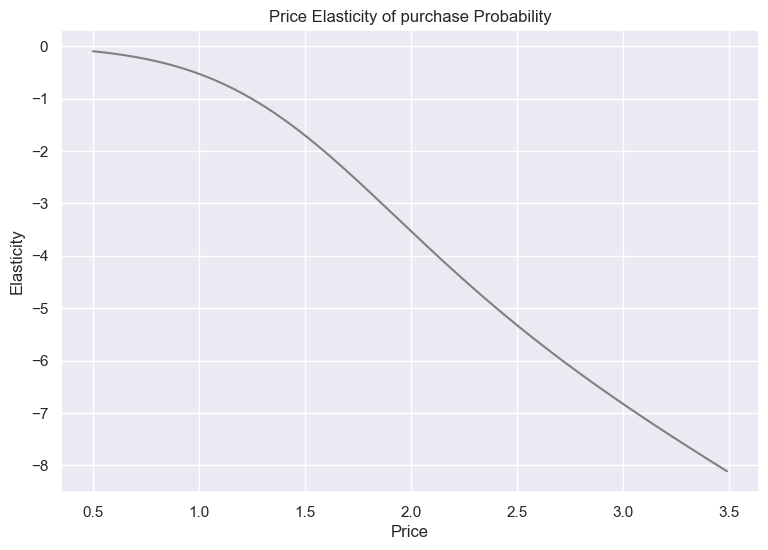

In [33]:
plt.figure(figsize=(9,6))
plt.plot(price_range, pe, color ='grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of purchase Probability')

Le elastità sono tutte negative. Dato che il prezzo e l'eleasticità sono inversamente proporzionali

## Purchase probability by Segments

### Segment 1

In [34]:
df_pa_segment_1 = df_pa[df_pa['segment']==1]

In [35]:
Y = df_pa_segment_1['Incidence']

In [36]:
X = pd.DataFrame()

In [37]:
X['Mean_Price']=(df_pa_segment_1['Price_1']+
                 df_pa_segment_1['Price_2']+
                 df_pa_segment_1['Price_3']+
                 df_pa_segment_1['Price_4']+
                 df_pa_segment_1['Price_5'])/5

In [38]:
model_incidence_segment_1 =LogisticRegression(solver = 'sag')
model_incidence_segment_1.fit(X, Y)

LogisticRegression(solver='sag')

In [39]:
Y_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
pur_prob_segment1 = Y_segment_1[:][:, 1]
pe_sgement_1 = model_incidence_segment_1.coef_[:,0] * price_range * (1 - pur_prob_segment1)

C:\Users\armaod\AppData\Local\anaconda3\envs\PayInt\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Result

In [40]:
df_price_elasticity['PE_segment1']=pe_sgement_1
df_price_elasticity

,Price_Point,Mean_Pe,PE_segment1
0,0.50,-0.096379,-0.069386
1,0.51,-0.100447,-0.072453
2,0.52,-0.104641,-0.075625
3,0.53,-0.108965,-0.078904
4,0.54,-0.113423,-0.082292
5,0.55,-0.118018,-0.085794
6,0.56,-0.122752,-0.089412
7,0.57,-0.127629,-0.093149
8,0.58,-0.132654,-0.097008
9,0.59,-0.137828,-0.100994


Text(0.5, 1.0, 'Price Elasticity of purchase Probability')

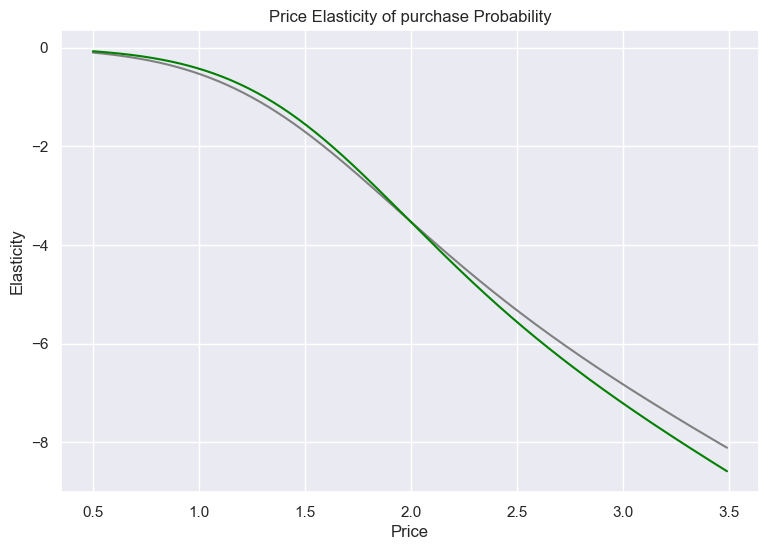

In [41]:
plt.figure(figsize=(9,6))
plt.plot(price_range, pe, color ='grey')
plt.plot(price_range, pe_sgement_1, color ='green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of purchase Probability')

### Segment 2

In [42]:
df_pa_segment_2 = df_pa[df_pa['segment']==2]

Y = df_pa_segment_2['Incidence']

X = pd.DataFrame()

X['Mean_Price']=(df_pa_segment_2['Price_1']+
                 df_pa_segment_2['Price_2']+
                 df_pa_segment_2['Price_3']+
                 df_pa_segment_2['Price_4']+
                 df_pa_segment_2['Price_5'])/5

model_incidence_segment_2 =LogisticRegression(solver = 'sag')
model_incidence_segment_2.fit(X, Y)

Y_segment_2 = model_incidence_segment_2.predict_proba(df_price_range)
pur_prob_segment2 = Y_segment_2[:][:, 1]
pe_sgement_2 = model_incidence_segment_2.coef_[:,0] * price_range * (1 - pur_prob_segment2)

df_price_elasticity['PE_segment2']=pe_sgement_2
df_price_elasticity

C:\Users\armaod\AppData\Local\anaconda3\envs\PayInt\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,Price_Point,Mean_Pe,PE_segment1,PE_segment2
0,0.50,-0.096379,-0.069386,-0.159250
1,0.51,-0.100447,-0.072453,-0.164212
2,0.52,-0.104641,-0.075625,-0.169257
3,0.53,-0.108965,-0.078904,-0.174387
4,0.54,-0.113423,-0.082292,-0.179602
5,0.55,-0.118018,-0.085794,-0.184902
6,0.56,-0.122752,-0.089412,-0.190290
7,0.57,-0.127629,-0.093149,-0.195764
8,0.58,-0.132654,-0.097008,-0.201327
9,0.59,-0.137828,-0.100994,-0.206979


Text(0.5, 1.0, 'Price Elasticity of purchase Probability')

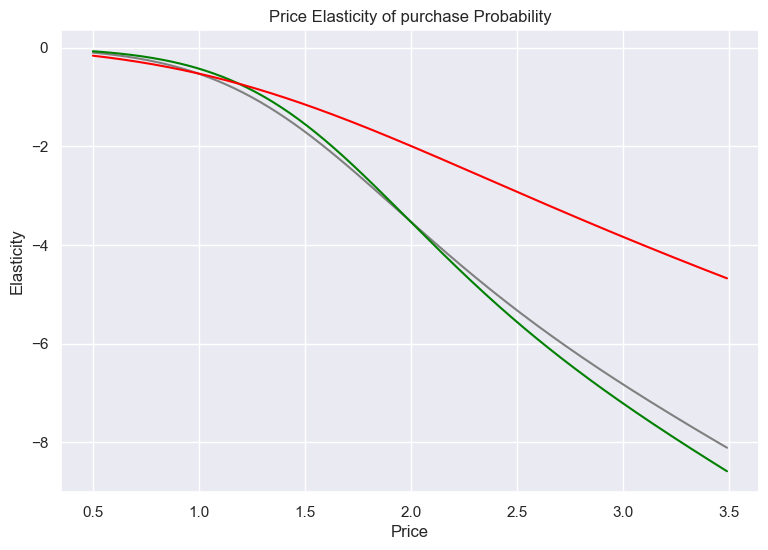

In [43]:
plt.figure(figsize=(9,6))
plt.plot(price_range, pe, color ='grey')
plt.plot(price_range, pe_sgement_1, color ='green')
plt.plot(price_range, pe_sgement_2, color ='red')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of purchase Probability')

## Purchase probability with promotion features

### Data Preparation

In [44]:
Y = df_pa['Incidence']

In [45]:
X = pd.DataFrame()
X['Mean price']=(df_pa['Price_1']+
                 df_pa['Price_2']+
                 df_pa['Price_3']+
                 df_pa['Price_4']+
                 df_pa['Price_5'])/5

In [46]:
X['Mean Promotion']=(df_pa['Promotion_1']+
                     df_pa['Promotion_2']+
                     df_pa['Promotion_3']+
                     df_pa['Promotion_4']+
                     df_pa['Promotion_5'])/5
X.head(10)

,Mean price,Mean Promotion
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0
3,2.028,0.0
4,2.030,0.0
5,2.028,0.0
6,2.030,0.0
7,2.030,0.0
8,1.932,0.6
9,1.932,0.6


In [47]:
model_incidence_promotion =LogisticRegression(solver = 'sag')
model_incidence_promotion.fit(X, Y)
model_incidence_promotion.coef_

array([[-1.49455054,  0.56074937]])

I coefficenti mostrano come la probabilità di acquisto sia inversamente proporzinale al prezzo, mentre la promozione abbiamo un effettto positivo sulla probabilità

### Price elasticity with promotion

In [48]:
df_price_elasticity_promotion = pd.DataFrame(price_range)
df_price_elasticity_promotion = df_price_elasticity_promotion.rename(columns = {0 : "Price_range"})

In [49]:
df_price_elasticity_promotion['Promotion']=1

In [50]:
Y_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion.values)

C:\Users\armaod\AppData\Local\anaconda3\envs\PayInt\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [51]:
promo = Y_promotion[:, 1]
price_eslasticity_promo = model_incidence_promotion.coef_[:,0] * price_range * (1 - promo)

In [52]:
df_price_elasticity['Elasticity_Promotion_1'] = price_eslasticity_promo
df_price_elasticity.head()

,Price_Point,Mean_Pe,PE_segment1,PE_segment2,Elasticity_Promotion_1
0,0.50,-0.096379,-0.069386,-0.159250,-0.125778
1,0.51,-0.100447,-0.072453,-0.164212,-0.129896
2,0.52,-0.104641,-0.075625,-0.169257,-0.134093
3,0.53,-0.108965,-0.078904,-0.174387,-0.138371
4,0.54,-0.113423,-0.082292,-0.179602,-0.142729


### Price elasticity without promotion

In [53]:
df_price_elasticity_promotion['No_Promotion']=0

Y_no_promotion = model_incidence_promotion.predict_proba(df_price_elasticity_promotion[['Price_range', 'No_Promotion']].values)

no_promo = Y_no_promotion[:, 1]
price_eslasticity_no_promo = model_incidence_promotion.coef_[:,0] * price_range * (1 - no_promo)

df_price_elasticity['Elasticity_no_Promotion'] = price_eslasticity_no_promo
df_price_elasticity.head()

C:\Users\armaod\AppData\Local\anaconda3\envs\PayInt\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,Price_Point,Mean_Pe,PE_segment1,PE_segment2,Elasticity_Promotion_1,Elasticity_no_Promotion
0,0.50,-0.096379,-0.069386,-0.159250,-0.125778,-0.195604
1,0.51,-0.100447,-0.072453,-0.164212,-0.129896,-0.201725
2,0.52,-0.104641,-0.075625,-0.169257,-0.134093,-0.207949
3,0.53,-0.108965,-0.078904,-0.174387,-0.138371,-0.214276
4,0.54,-0.113423,-0.082292,-0.179602,-0.142729,-0.220707


Text(0.5, 1.0, 'Price Elasticity of purchase Probability eith and without promotion')

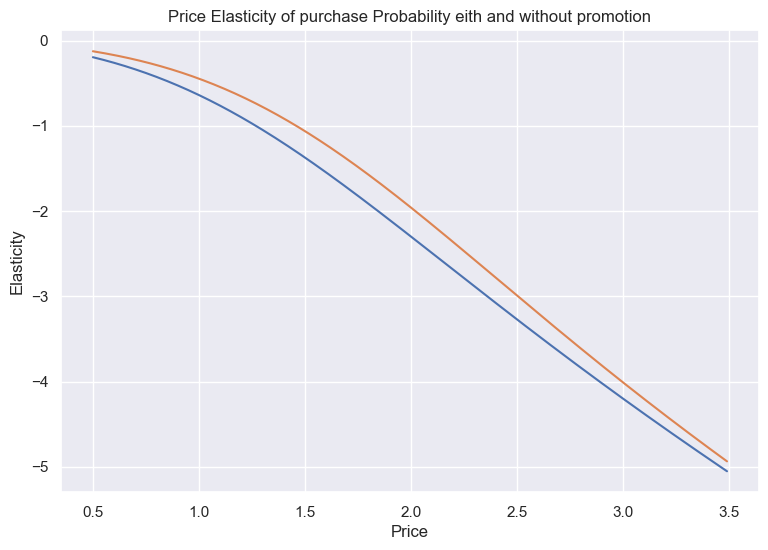

In [54]:
plt.figure(figsize=(9,6))
plt.plot(price_range, price_eslasticity_no_promo) #blue
plt.plot(price_range, price_eslasticity_promo) #orange
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of purchase Probability eith and without promotion')

## Brand Choice

### Data preparation

In [55]:
brand_choice = df_pa[df_pa['Incidence']==1]

In [56]:
pd.options.display.max_rows =100
brand_choice

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,segment,segment_0,segment_1,segment_2,segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,1,0,1,0,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,1,0,1,0,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,1,0,1,0,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,1,0,1,0,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58621,200000500,296,1,2,6,0,0,1.48,1.89,2.01,...,42,1,120946,1,0,1,0,1,0,0
58648,200000500,460,1,1,12,0,0,1.35,1.57,2.02,...,42,1,120946,1,0,1,0,1,0,0
58674,200000500,641,1,2,7,0,0,1.50,1.85,2.06,...,42,1,120946,1,0,1,0,1,0,0
58687,200000500,697,1,2,6,0,0,1.42,1.51,1.97,...,42,1,120946,1,0,1,0,1,0,0


In [57]:
Y = brand_choice['Brand']

In [58]:
brand_choice.columns

Index(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3', 'Promotion_4',
       'Promotion_5', 'Sex', 'Marital status', 'Age', 'Education', 'Income',
       'Occupation', 'Settlement size', 'segment', 'segment_0', 'segment_1',
       'segment_2', 'segment_3'],
      dtype='object')

In [59]:
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4','Price_5']
X = brand_choice[features]

In [60]:
model_brand_choice = LogisticRegression(solver = 'sag', multi_class='multinomial' )
model_brand_choice.fit(X, Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [61]:
model_brand_choice.coef_

array([[-3.91595907,  0.65845784,  2.4177148 ,  0.70408203, -0.20210902],
       [ 1.27461031, -1.87985643, -0.21265695, -0.20634247,  0.587868  ],
       [ 1.62419799,  0.56211501,  0.50092767,  1.03951497,  0.45279554],
       [ 0.57453367,  0.39558649, -1.40062323, -1.24624571,  0.2493472 ],
       [ 0.4426171 ,  0.26369709, -1.30536229, -0.29100881, -1.08790172]])

In [62]:
bc_coef = pd.DataFrame(model_brand_choice.coef_)
bc_coef

,0,1,2,3,4
0,-3.915959,0.658458,2.417715,0.704082,-0.202109
1,1.274610,-1.879856,-0.212657,-0.206342,0.587868
2,1.624198,0.562115,0.500928,1.039515,0.452796
3,0.574534,0.395586,-1.400623,-1.246246,0.249347
4,0.442617,0.263697,-1.305362,-0.291009,-1.087902


In [63]:
bc_coef = pd.DataFrame(np.transpose(model_brand_choice.coef_))
coefficients = ['Coef_Brand_1','Coef_Brand_2','Coef_Brand_3','Coef_Brand_4','Coef_Brand_5']
bc_coef.columns = [coefficients]
prices = ['price_1','price_2','price_3','price_4','price_5']
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
price_1,-3.92,1.27,1.62,0.57,0.44
price_2,0.66,-1.88,0.56,0.40,0.26
price_3,2.42,-0.21,0.50,-1.40,-1.31
price_4,0.70,-0.21,1.04,-1.25,-0.29
price_5,-0.20,0.59,0.45,0.25,-1.09


## Own Price Elasticity Brand 5

In [64]:
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))
df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
...,...,...,...,...,...
295,1.384559,1.764717,2.006694,2.159658,3.45
296,1.384559,1.764717,2.006694,2.159658,3.46
297,1.384559,1.764717,2.006694,2.159658,3.47
298,1.384559,1.764717,2.006694,2.159658,3.48


In [65]:
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

In [66]:
pr_own_brand_5 = predict_brand_5 [:][:, 4]

Siamo interessanti nel coefficente del prezzo del brand 5 che è = -1.09

In [67]:
beta5 = bc_coef.iloc[4,4]
beta5

-1.09

In [68]:
price_eslasticity_brand5 = beta5 * price_range * (1 - pr_own_brand_5)

Text(0.5, 1.0, 'Price Elasticity of purchase Probability eith and without promotion')

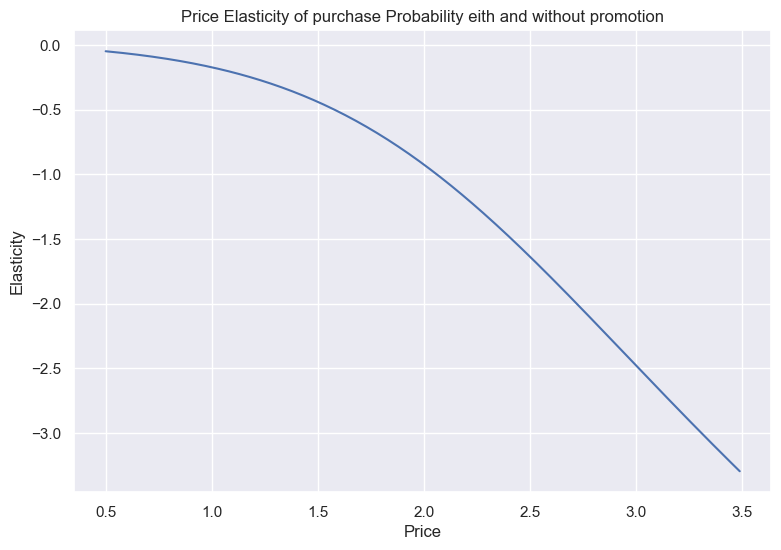

In [69]:
plt.figure(figsize=(9,6))
plt.plot(price_range, price_eslasticity_brand5) #blue
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elasticity of purchase Probability eith and without promotion')

## Cross price Elasticity Brand 5 Cross Brand 4

In [70]:
df_brand5_cross_brand4 = pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4['Price_1'] = brand_choice['Price_1'].mean()
df_brand5_cross_brand4['Price_2'] = brand_choice['Price_2'].mean()
df_brand5_cross_brand4['Price_3'] = brand_choice['Price_3'].mean()
df_brand5_cross_brand4['Price_4'] = price_range
df_brand5_cross_brand4['Price_5'] = brand_choice['Price_5'].mean()

In [71]:
df_brand5_cross_brand4.head()

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,0.50,2.654296
1,1.384559,1.764717,2.006694,0.51,2.654296
2,1.384559,1.764717,2.006694,0.52,2.654296
3,1.384559,1.764717,2.006694,0.53,2.654296
4,1.384559,1.764717,2.006694,0.54,2.654296


In [72]:
predict_brand5_cross_brand4 = model_brand_choice.predict_proba(df_brand5_cross_brand4)

Formula elasticità tra brand E = -beta(own_price)*price(cross brand) *pr(cross brand)

In [73]:
pr_brand4 = predict_brand5_cross_brand4[:][:,3]

In [74]:
beta5

-1.09

In [75]:
brand5_cross_brand4_elasticity = -beta5 * price_range * pr_brand4 

In [76]:
df_price_elasticity['brand5_cross_brand4'] = brand5_cross_brand4_elasticity
df_price_elasticity

,Price_Point,Mean_Pe,PE_segment1,PE_segment2,Elasticity_Promotion_1,Elasticity_no_Promotion,brand5_cross_brand4
0,0.50,-0.096379,-0.069386,-0.159250,-0.125778,-0.195604,0.332011
1,0.51,-0.100447,-0.072453,-0.164212,-0.129896,-0.201725,0.337288
2,0.52,-0.104641,-0.075625,-0.169257,-0.134093,-0.207949,0.342507
3,0.53,-0.108965,-0.078904,-0.174387,-0.138371,-0.214276,0.347669
4,0.54,-0.113423,-0.082292,-0.179602,-0.142729,-0.220707,0.352773
...,...,...,...,...,...,...,...
295,3.45,-8.013326,-8.484036,-4.610295,-4.863761,-4.985116,0.162234
296,3.46,-8.038576,-8.510909,-4.626956,-4.881966,-5.002028,0.160334
297,3.47,-8.063793,-8.537741,-4.643595,-4.900141,-5.018919,0.158448
298,3.48,-8.088976,-8.564531,-4.660211,-4.918285,-5.035791,0.156577


Text(0.5, 1.0, 'cross price elasticity of brand 5 wrt brand 4')

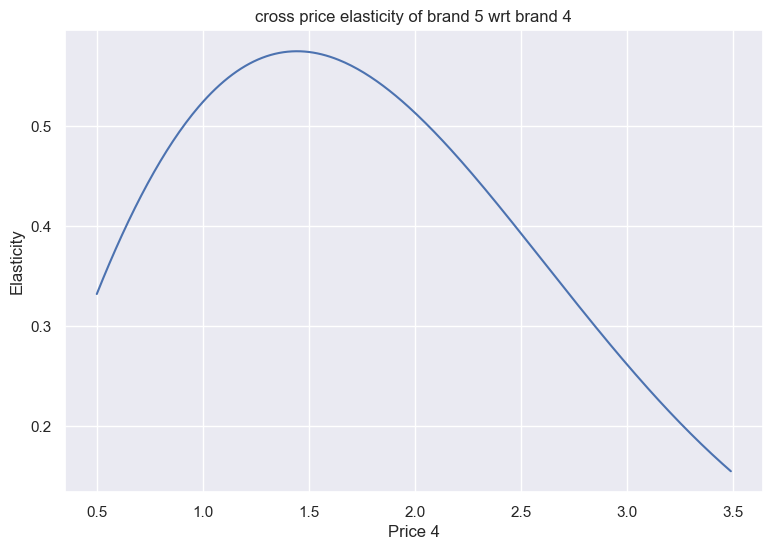

In [77]:
plt.figure(figsize=(9,6))
plt.plot(price_range, brand5_cross_brand4_elasticity) #blue
plt.xlabel('Price 4')
plt.ylabel('Elasticity')
plt.title('cross price elasticity of brand 5 wrt brand 4')

Essendo positiva l'elesticità indica che i due brand sono sostituiti. Il brand 4 è un forte sostituto del brand 5. Ha sostanzialmente un prezzo più basso del 5. Incrementando il prezzo oltre 1.5 si vede come l'elasticità tra il brand 4 e 5, diminusica molto velocemente.

## Own and Cross-Price Elasticity by Segment

### Well-Off

In [78]:
brand_choice_s3 = df_pa[(df_pa['Incidence']==1) & (df_pa['segment'] == 3)]
brand_choice_s3

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,segment,segment_0,segment_1,segment_2,segment_3
291,200000004,55,1,5,1,0,0,1.39,1.90,1.91,...,37,1,119602,0,0,3,0,0,0,1
303,200000004,162,1,5,1,0,0,1.39,1.90,1.94,...,37,1,119602,0,0,3,0,0,0,1
304,200000004,175,1,5,1,5,1,1.48,1.50,1.97,...,37,1,119602,0,0,3,0,0,0,1
306,200000004,184,1,5,1,0,0,1.46,1.88,1.97,...,37,1,119602,0,0,3,0,0,0,1
307,200000004,194,1,5,2,5,1,1.35,1.56,1.99,...,37,1,119602,0,0,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58554,200000499,617,1,2,2,0,0,1.48,1.57,2.06,...,35,1,73266,0,0,3,0,0,0,1
58559,200000499,659,1,2,3,0,0,1.26,1.88,2.06,...,35,1,73266,0,0,3,0,0,0,1
58560,200000499,662,1,4,3,2,1,1.37,1.80,2.06,...,35,1,73266,0,0,3,0,0,0,1
58565,200000499,696,1,2,5,0,0,1.42,1.51,1.97,...,35,1,73266,0,0,3,0,0,0,1


In [79]:
# Model estimation
Y = brand_choice_s3['Brand']
brand_choice_s3 = pd.get_dummies(brand_choice_s3, columns=['Brand'], prefix = 'Brand', prefix_sep='_')
X = brand_choice_s3[features]
model_brand_choice_s3 = LogisticRegression(solver = 'sag', multi_class='multinomial', max_iter=300)
model_brand_choice_s3.fit(X, Y)

#Coefficient table for segment
bc_coef = pd.DataFrame(np.transpose(model_brand_choice_s3.coef_))
bc_coef.columns = [coefficients]
bc_coef.index = [prices]
bc_coef = bc_coef.round(2)
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
price_1,-3.68,1.17,1.38,0.42,0.72
price_2,0.38,-2.17,0.30,0.37,1.12
price_3,1.55,-0.22,0.18,-0.28,-1.23
price_4,1.21,-0.10,1.07,-1.53,-0.66
price_5,0.61,0.97,0.73,0.24,-2.54


In [80]:
b5=bc_coef.iloc[4,4]

### Own brand price elasticity segment

In [81]:
df_own_brand5_cross_brand4_s3= pd.DataFrame(index = np.arange(price_range.size))
df_own_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_own_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_own_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_own_brand5_cross_brand4_s3['Price_4'] = price_range
df_own_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_brand5_brand4_s3 = model_brand_choice_s3.predict_proba(df_own_brand5_cross_brand4_s3.values)
pr_brand5_brand4_s3 = predict_brand5_brand4_s3[:][: , 4]

price_elasticity_brand5_s3 = b5 * price_range * (1-pr_brand5_brand4_s3)
df_price_elasticity['price_elasticity_brand5_s3'] = price_elasticity_brand5_s3
df_price_elasticity

C:\Users\armaod\AppData\Local\anaconda3\envs\PayInt\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,Price_Point,Mean_Pe,PE_segment1,PE_segment2,Elasticity_Promotion_1,Elasticity_no_Promotion,brand5_cross_brand4,price_elasticity_brand5_s3
0,0.50,-0.096379,-0.069386,-0.159250,-0.125778,-0.195604,0.332011,-1.048523
1,0.51,-0.100447,-0.072453,-0.164212,-0.129896,-0.201725,0.337288,-1.069128
2,0.52,-0.104641,-0.075625,-0.169257,-0.134093,-0.207949,0.342507,-1.089730
3,0.53,-0.108965,-0.078904,-0.174387,-0.138371,-0.214276,0.347669,-1.110328
4,0.54,-0.113423,-0.082292,-0.179602,-0.142729,-0.220707,0.352773,-1.130924
...,...,...,...,...,...,...,...,...
295,3.45,-8.013326,-8.484036,-4.610295,-4.863761,-4.985116,0.162234,-8.486882
296,3.46,-8.038576,-8.510909,-4.626956,-4.881966,-5.002028,0.160334,-8.515118
297,3.47,-8.063793,-8.537741,-4.643595,-4.900141,-5.018919,0.158448,-8.543339
298,3.48,-8.088976,-8.564531,-4.660211,-4.918285,-5.035791,0.156577,-8.571545


### Cross brand price elasticity segment

In [84]:
df_brand5_cross_brand4_s3= pd.DataFrame(index = np.arange(price_range.size))
df_brand5_cross_brand4_s3['Price_1'] = brand_choice_s3['Price_1'].mean()
df_brand5_cross_brand4_s3['Price_2'] = brand_choice_s3['Price_2'].mean()
df_brand5_cross_brand4_s3['Price_3'] = brand_choice_s3['Price_3'].mean()
df_brand5_cross_brand4_s3['Price_4'] = price_range
df_brand5_cross_brand4_s3['Price_5'] = brand_choice_s3['Price_5'].mean()

predict_cross_brand5_brand4_s3 = model_brand_choice_s3.predict_proba(df_own_brand5_cross_brand4_s3.values)
pr_cross_brand5_s3 = predict_cross_brand5_brand4_s3[:][: , 3]

brand5_cross_brand4_price_elasticity_s3 = -beta5 * price_range * pr_cross_brand5_s3
df_price_elasticity['brand5_cross_brand4_price_elasticity_s3'] = brand5_cross_brand4_price_elasticity_s3
df_price_elasticity

C:\Users\armaod\AppData\Local\anaconda3\envs\PayInt\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,Price_Point,Mean_Pe,PE_segment1,PE_segment2,Elasticity_Promotion_1,Elasticity_no_Promotion,brand5_cross_brand4,price_elasticity_brand5_s3,brand5_cross_brand4_price_elasticity_s3
0,0.50,-0.096379,-0.069386,-0.159250,-0.125778,-0.195604,0.332011,-1.048523,0.245873
1,0.51,-0.100447,-0.072453,-0.164212,-0.129896,-0.201725,0.337288,-1.069128,0.249011
2,0.52,-0.104641,-0.075625,-0.169257,-0.134093,-0.207949,0.342507,-1.089730,0.252080
3,0.53,-0.108965,-0.078904,-0.174387,-0.138371,-0.214276,0.347669,-1.110328,0.255080
4,0.54,-0.113423,-0.082292,-0.179602,-0.142729,-0.220707,0.352773,-1.130924,0.258012
...,...,...,...,...,...,...,...,...,...
295,3.45,-8.013326,-8.484036,-4.610295,-4.863761,-4.985116,0.162234,-8.486882,0.023297
296,3.46,-8.038576,-8.510909,-4.626956,-4.881966,-5.002028,0.160334,-8.515118,0.022857
297,3.47,-8.063793,-8.537741,-4.643595,-4.900141,-5.018919,0.158448,-8.543339,0.022425
298,3.48,-8.088976,-8.564531,-4.660211,-4.918285,-5.035791,0.156577,-8.571545,0.021999


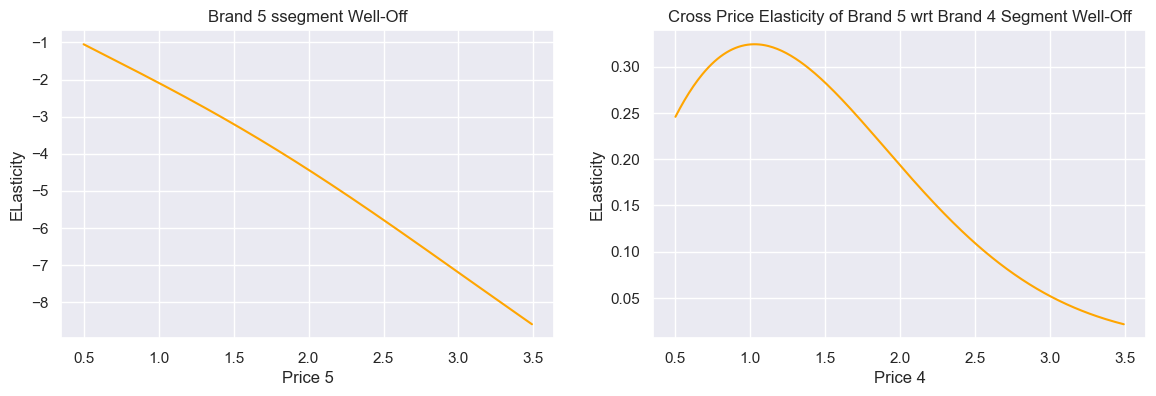

In [87]:
fig, axes = plt.subplots(1,2, figsize = (14,4))
axes[0].plot(price_range, price_elasticity_brand5_s3, color = 'orange')
axes[0].set_title('Brand 5 ssegment Well-Off')
axes[0].set_xlabel('Price 5')

axes[1].plot(price_range, brand5_cross_brand4_price_elasticity_s3, color = 'orange')
axes[1].set_title('Cross Price Elasticity of Brand 5 wrt Brand 4 Segment Well-Off')
axes[1].set_xlabel('Price 4')

for ax in axes.flat:
    ax.set(ylabel = 'ELasticity')